# Extending FECT: QUD-based Factuality Assessment

Cresta's [KDD paper](https://kdd-eval-workshop.github.io/genai-evaluation-kdd2025/assets/papers/Submission%2022.pdf) on factuality assessment proposed the `3D paradigm` for factuality evaluation in an LLM-as-judge framework.

Here, we try to build on this approach by directing the LLM to process conversational data through the Question Under Discussion (QUD) framework.

We use the [synthetic datasets](https://github.com/cresta/fect) published alongside the original paper to compare the original 3D paradigm to the novel QUD-based approach, focusing on the OpenAI models only.

In [ ]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime


data = []
for p in Path("../data").resolve().glob("*.json"):
    model, prompt, ttc, date, time = re.search(r'fect_benchmark_results_(.*?)_([0-9A-Z]*)_([0-9A-Z]*_[0-9A-Z]*)_([0-9A-Z]*)_([0-9A-Z]*).json', p.name).groups()
    with open(p, 'r') as f:
        f1_score = json.load(f)['False']['f1-score']

    data.append((model, prompt, ttc, f1_score))
    
df = pd.DataFrame(data, columns=['model', 'prompt', 'ttc', 'f1_score'])
print(df.sort_values('f1_score', ascending=False).round(2))

                      model prompt       ttc  f1_score
0   gpt-4.1-mini-2025-04-14     3D    NO_TTC      0.70
5   gpt-4.1-mini-2025-04-14    QUD  WITH_TTC      0.66
1   gpt-4.1-mini-2025-04-14     3D  WITH_TTC      0.63
4   gpt-4.1-mini-2025-04-14    QUD    NO_TTC      0.63
2   gpt-4.1-mini-2025-04-14  BASIC    NO_TTC      0.59
3   gpt-4.1-mini-2025-04-14  BASIC  WITH_TTC      0.53
6   gpt-4.1-nano-2025-04-14     3D    NO_TTC      0.52
10  gpt-4.1-nano-2025-04-14    QUD    NO_TTC      0.49
8   gpt-4.1-nano-2025-04-14  BASIC    NO_TTC      0.39
7   gpt-4.1-nano-2025-04-14     3D  WITH_TTC      0.35
9   gpt-4.1-nano-2025-04-14  BASIC  WITH_TTC      0.31
11  gpt-4.1-nano-2025-04-14    QUD  WITH_TTC      0.24


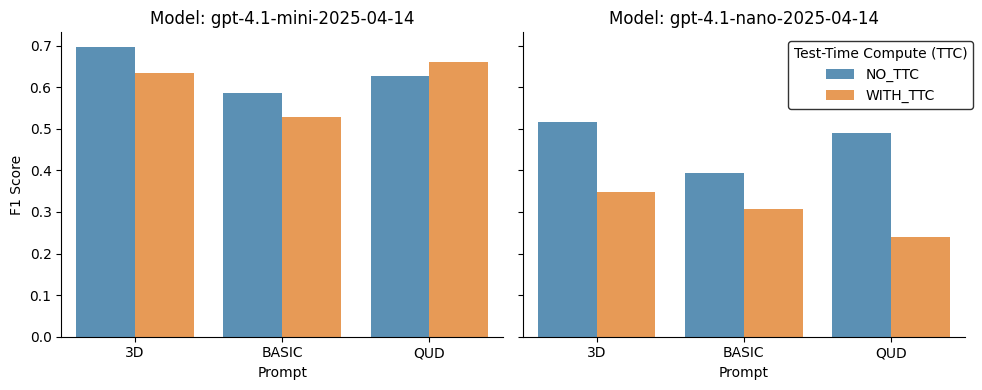

In [82]:
# Create facets for each model
g = sns.FacetGrid(df, col='model', col_wrap=2, height=4, aspect=1)

# Map barplot to each facet
def plot_bars(data, **kwargs):
    ax = plt.gca()
    sns.barplot(
        data=data, 
        x='prompt', 
        y='f1_score', 
        hue='ttc',
        alpha=0.8,
        ax=ax
    )
    ax.set_title(f"Model: {data['model'].iloc[0]}")
    ax.set_xlabel('Prompt')
    ax.set_ylabel('F1 Score')

g.map_dataframe(plot_bars)
g.add_legend(title='Test-Time Compute (TTC)', bbox_to_anchor=(1.0, 0.8), frameon=True, edgecolor='black')
plt.tight_layout()
plt.show()

The initial comparison suggests that we might be onto something here: the QUD prompt does significantly better than the BASIC prompt, and is comparable to the 3D paradigm prompt.

Note that it also reverts one of the counterintuitive findings from the original paper, namely that test-time compute (TTC) tended to degrade performance under the 3D paradigm: the QUD prompt appears to actually benefit from TTC, at least with the more sophisticated `gpt-4.1-mini` model.